# Rossemann销售额预测

In [1]:
#载入所需的库
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import xgboost as xgb

In [3]:
raw_train_df  = pd.read_csv("data/train.csv")
store_df     = pd.read_csv("data/store.csv")
#test中无customer和sales
raw_test_df = pd.read_csv("data/test.csv")

D:\Users\Dafengzai\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 数据中一些（元素）列的注释
**Promo**:当天是否促销。  
**Promo2**:是否有促销季（国庆钜惠之类的）: 0 = store is not participating, 1 = store is participating
**PromoInterval**:促销间隔，促销季开始的月份，"Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store  
**StateHoliday**: 商店一般都在holiday关门。a = public holiday, b = Easter holiday, c = Christmas, 0 = None(Note that all schools are closed on public holidays and weekends.)  
**SchoolHoliday**:商店是否受学校放假的影响（1为肯定）


## 原始数据处理

In [20]:
#引入"MeanLogSalesByStore"
store_df["MeanLogSalesByStore"] = [np.log1p(raw_train_df[raw_train_df.Store == store_num].Sales.mean()) for store_num in store_df.Store]
    
#因为raw_test_df中有"StateHoliday" ,因此引入"MeanLogSalesByStateHoliday"
MeanLogSalesToEachStateHoliday = {0: np.log1p(raw_train_df.loc[(raw_train_df.StateHoliday==0)|(raw_train_df.StateHoliday=='0')].Sales.mean()),
                                   '0': np.log1p(raw_train_df.loc[(raw_train_df.StateHoliday==0)|(raw_train_df.StateHoliday=='0')].Sales.mean()),
                                   'a': np.log1p(raw_train_df.loc[raw_train_df.StateHoliday=='a'].Sales.mean()),
                                   'b': np.log1p(raw_train_df.loc[raw_train_df.StateHoliday=='b'].Sales.mean()),
                                   'c': np.log1p(raw_train_df.loc[raw_train_df.StateHoliday=='c'].Sales.mean())}
                                                
#引入"MeanLogSalesByStore_DayOfWeek"的准备工作
store_df["MeanLogSalesByStore_DayOfWeek1"] = [np.log1p(raw_train_df.loc[(raw_train_df.Store==store_num)&(raw_train_df.DayOfWeek==1)].Sales.mean()) for store_num in store_df.Store]
store_df["MeanLogSalesByStore_DayOfWeek2"] = [np.log1p(raw_train_df.loc[(raw_train_df.Store==store_num)&(raw_train_df.DayOfWeek==2)].Sales.mean()) for store_num in store_df.Store]                                                
store_df["MeanLogSalesByStore_DayOfWeek3"] = [np.log1p(raw_train_df.loc[(raw_train_df.Store==store_num)&(raw_train_df.DayOfWeek==3)].Sales.mean()) for store_num in store_df.Store]
store_df["MeanLogSalesByStore_DayOfWeek4"] = [np.log1p(raw_train_df.loc[(raw_train_df.Store==store_num)&(raw_train_df.DayOfWeek==4)].Sales.mean()) for store_num in store_df.Store]
store_df["MeanLogSalesByStore_DayOfWeek5"] = [np.log1p(raw_train_df.loc[(raw_train_df.Store==store_num)&(raw_train_df.DayOfWeek==5)].Sales.mean()) for store_num in store_df.Store]                                                
store_df["MeanLogSalesByStore_DayOfWeek6"] = [np.log1p(raw_train_df.loc[(raw_train_df.Store==store_num)&(raw_train_df.DayOfWeek==6)].Sales.mean()) for store_num in store_df.Store]                                                
store_df["MeanLogSalesByStore_DayOfWeek7"] = [np.log1p(raw_train_df.loc[(raw_train_df.Store==store_num)&(raw_train_df.DayOfWeek==7)].Sales.mean()) for store_num in store_df.Store]            

#引入"MeanLogSalesByStore_Promo"的准备工作
store_df['MeanLogSalesByStore_Promo1'] = [np.log1p(raw_train_df.loc[(raw_train_df.Store==store_num)&(raw_train_df.Promo==1)].Sales.mean()) for store_num in store_df.Store]
store_df['MeanLogSalesByStore_Promo0'] = [np.log1p(raw_train_df.loc[(raw_train_df.Store==store_num)&(raw_train_df.Promo==0)].Sales.mean()) for store_num in store_df.Store]


In [21]:
store_df.CompetitionDistance.fillna(store_df.CompetitionDistance.median(), inplace=True)
store_df.fillna(0, inplace=True)
#若商店不开门（open==0） 营业额也为0，所以要将这些数据行删除
raw_train_df = raw_train_df.drop(raw_train_df[raw_train_df.Open==0].index)
#商店开门但却没有营业额的情况，一般认为这是不正常的,删除
raw_train_df = raw_train_df.drop(raw_train_df[(raw_train_df.Open==1)&(raw_train_df.Sales==0)].index)

def build_train_df(raw_train_df):

    
    train_df = pd.merge(raw_train_df, store_df, on='Store', how='inner')
    
    #引入"MeanLogSalesByStateHoliday"
    train_df["MeanLogSalesByStateHoliday"] = train_df.StateHoliday.map(MeanLogSalesToEachStateHoliday)
    #引入"MeanLogSalesByStore_DayOfWeek"
    train_df["MeanLogSalesByStore_DayOfWeek"] = [train_df.iloc[i]["MeanLogSalesByStore_DayOfWeek"+str(train_df.iloc[i].DayOfWeek)] for i in train_df.index]
    #引入"MeanLogSalesByStore_Promo"
    train_df["MeanLogSalesByStore_Promo"] = [train_df.iloc[i]["MeanLogSalesByStore_Promo"+str(train_df.iloc[i].Promo)] for i in train_df.index]
    
    #将时间元素拆开成年月日
    train_df['Year'] = [int(date.split('-')[0]) for date in train_df.Date]
    train_df['Month'] = [int(date.split('-')[1]) for date in train_df.Date]
    train_df['Day'] = [int(date.split('-')[2]) for date in train_df.Date]
    
    #对日期数据进行处理，加入DayOfYear
    #因为数据集（包裹测试集）为2013-2015年的数据，所以不用考虑闰年
    dayofyear = []
    months = [31,28,31,30,31,30,31,31,30,31,30,31]
    for date in train_df.Date:
        month = int(date.split('-')[1])
        dayofmonth = int(date.split('-')[2])
        days = 0
        for i in range(month-1):
            days += months[i]
        days += dayofmonth
        dayofyear.append(days)
    train_df['DayOfYear'] = dayofyear
    
    #引入特征'WeekOfYear'
    import math
    train_df['WeekOfYear'] = [math.ceil(x/7) for x in train_df.DayOfYear]  #向上取整

    #将PromoInterval转化为是否有促销月:IsPromoMonth
    #这段代码来自<https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code>，之前都不知道PromoInterval怎么用
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    train_df['monthStr'] = train_df.Month.map(month2str)
    train_df.loc[train_df.PromoInterval == 0, 'PromoInterval'] = '' #把0变为空字符以便后面使用
    train_df['IsPromoMonth'] = 0
    for interval in train_df.PromoInterval.unique():
        if interval != '':   #不为空字符，即有PromoInterval
            for month in interval.split(','):
                train_df.loc[(train_df.monthStr == month) & (train_df.PromoInterval == interval), 'IsPromoMonth'] = 1
                
    
    
    #对于'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',我将其合并为表示竞争对手开店总月数的特征'CompetitionOpenMonth'
    train_df['CompetitionOpenMonth'] = 12 * (train_df.Year - train_df.CompetitionOpenSinceYear) + \
                                        (train_df.Month - train_df.CompetitionOpenSinceMonth)
        
    #对于'Promo2SinceWeek', 'Promo2SinceYear',我将其合并为表示商店参与促销季(Promo2)总月数的特征'Promo2OpenMonth'    
    train_df.loc[:,'Promo2OpenMonth'] = 12 * (train_df.Year - train_df.Promo2SinceYear) + \
                                        (train_df.WeekOfYear - train_df.Promo2SinceWeek) / 4.0
    train_df.loc[:,'Promo2OpenMonth'] = train_df.Promo2OpenMonth.apply(lambda x: x if x > 0 else 0) #同年参与促销季，参加前的周会出现负数
    train_df.loc[train_df.Promo2SinceYear == 0, 'Promo2OpenMonth'] = 0
        
    #进行one_hot_encoding
    to_replace = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    train_df.StoreType.replace(to_replace, inplace=True)
    train_df.Assortment.replace(to_replace, inplace=True)
    train_df.StateHoliday.replace(to_replace, inplace=True)
    
    return train_df
    
    

In [22]:
def build_test_df(raw_test_df):
    test_df = build_train_df(raw_test_df)
    return test_df

In [24]:
train_df = build_train_df(raw_train_df)

In [25]:
test_df = build_test_df(raw_test_df)

In [26]:
#存储数据集以便之后训练模型时使用
train_df.to_pickle("data/train_df.pkl")  
test_df.to_pickle("data/test_df.pkl") 

## 数据可视化探索

相关系数的分析

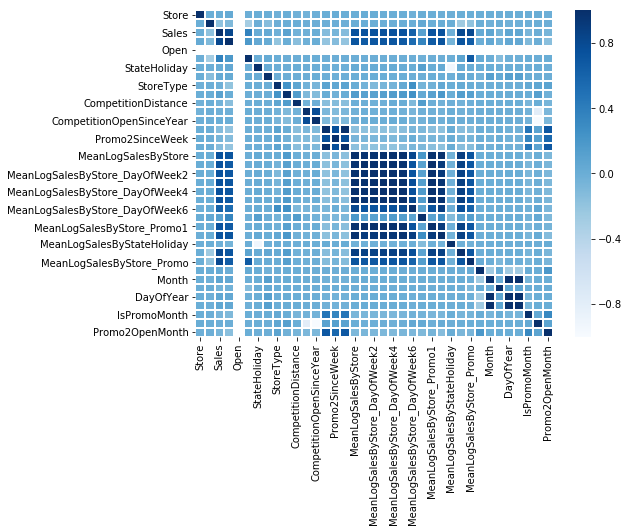

In [48]:
plt.figure(figsize = (8,6))
sns_plt = sns.heatmap(train_df.corr(), linewidths=1, cmap='Blues')

先按商店类型进行分析

In [49]:
train_df.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
1,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
2,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
3,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
4,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


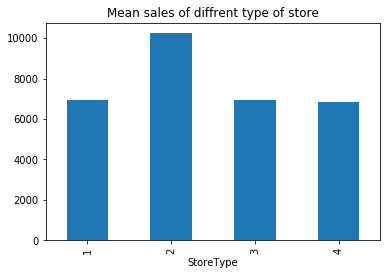

In [51]:
#各商店类型的平均销售额
plot = train_df.groupby('StoreType')['Sales'].mean().plot(kind='bar', title = "Mean sales of diffrent type of store")
fig = plot.get_figure()
fig.savefig('MarkdownImages/im2.png')

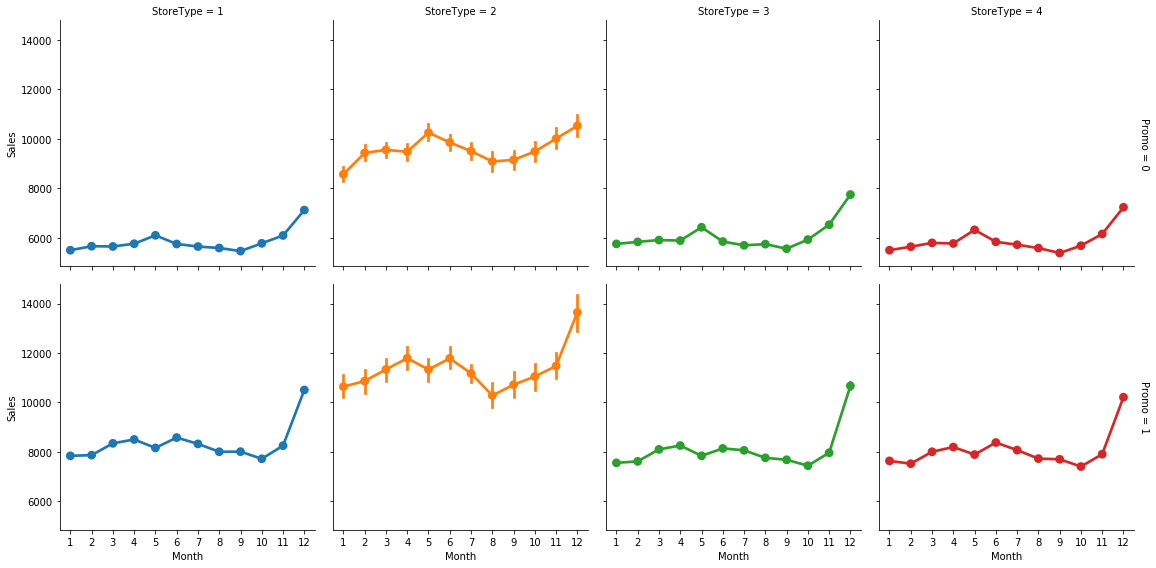

In [52]:
#按商店类型与是否促销来查看销售情况
snsplt = sns.factorplot(data = train_df, x='Month', y='Sales', margin_titles = True,
              row = 'Promo', col='StoreType',hue = 'StoreType')

可以看出出类型b（StoreType=2）之外其余商店类型销售额之间没有特别显著的差异，是否进行促销对销售额有较大的影响。

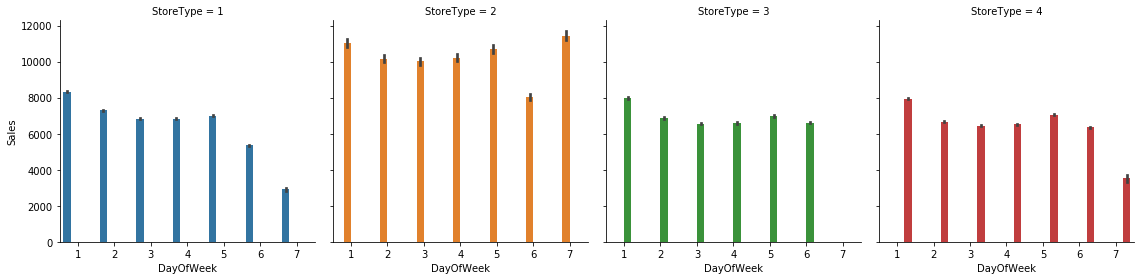

In [55]:
snsplt = sns.factorplot(data = train_df, x='DayOfWeek', y='Sales', margin_titles = True,
              col='StoreType',hue = 'StoreType',kind = 'bar')

可以看出销售额在一周的不同天数内会有所不同，类型c的商店则在周日不开业。

**因为该问题包含有时间数据，我认为销售额与时间数据间有一定的关联，下面使用时间特征对数据进行分析。**

In [56]:
#在各个类型的商店中各选取一个做例子
store_a = train_df[train_df.Store==np.random.choice(train_df[train_df.StoreType == 1].Store.unique())].set_index('Date').Sales
store_b = train_df[train_df.Store==np.random.choice(train_df[train_df.StoreType == 2].Store.unique())].set_index('Date').Sales
store_c = train_df[train_df.Store==np.random.choice(train_df[train_df.StoreType == 3].Store.unique())].set_index('Date').Sales
store_d = train_df[train_df.Store==np.random.choice(train_df[train_df.StoreType == 4].Store.unique())].set_index('Date').Sales

In [57]:
store_a.index = store_a.index.astype('datetime64')
store_b.index = store_b.index.astype('datetime64')
store_c.index = store_c.index.astype('datetime64')
store_d.index = store_d.index.astype('datetime64')

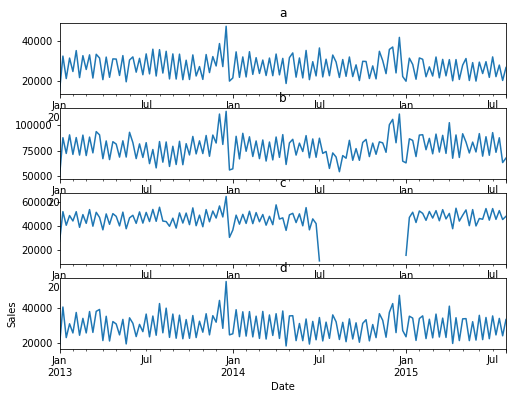

In [58]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(8,6))
plt.ylabel('Sales')
store_a.resample('W').sum().plot(ax = ax1, title = 'a')
store_b.resample('W').sum().plot(ax = ax2, title = 'b')
store_c.resample('W').sum().plot(ax = ax3, title = 'c')
store_d.resample('W').sum().plot(ax = ax4, title = 'd')

从上图可以看出，Sales与日期之间是有着相关性的，Sales随日期的变化而大致呈现出某种趋势。**因此对日期时间相关的特征要多注意。**

## 训练模型

### 选择的特征如下

In [27]:
features = ['Store', 'DayOfWeek',  'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
        'Promo2', 'Month', 'Day','Year','WeekOfYear','DayOfYear',
       'IsPromoMonth', 'CompetitionOpenMonth', 'Promo2OpenMonth',
        "MeanLogSalesByStore", "MeanLogSalesByStateHoliday",
        "MeanLogSalesByStore_DayOfWeek","MeanLogSalesByStore_Promo"]


In [50]:
train_df = pd.read_pickle("data/train_df.pkl")
test_df = pd.read_pickle("data/test_df.pkl")

### 分解数据集

对销售数据进行log处理

In [5]:
valid_df = pd.DataFrame(train_df.Sales)

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_df, np.log1p(valid_df), test_size = 0.025, random_state = 66, shuffle = True)

In [8]:
def rmspe_xg(preds, dtrain):
    labels = np.expm1(dtrain.get_label())
    preds = np.expm1(preds)
    score = np.sqrt(np.mean([((y_true-y_pred)/y_true)**2 for (y_pred, y_true) in zip(preds, labels) if y_true != 0]))
    return 'RMSPE', score

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.3,
          "silent": 1,
          "seed": 66
          }
num_boost_round = 4000

print("Train a XGBoost model")
dtrain = xgb.DMatrix(x_train[features], y_train)
dvalid = xgb.DMatrix(x_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=500, feval=rmspe_xg, verbose_eval=True)

#保存模型
gbm.save_model('data/xgboost_15_with_all_features_moretrain.model')

Train a XGBoost model
[0]	train-rmse:8.02126	eval-rmse:8.02031	train-RMSPE:0.999808	eval-RMSPE:0.999808
Multiple eval metrics have been passed: 'eval-RMSPE' will be used for early stopping.

Will train until eval-RMSPE hasn't improved in 500 rounds.
[1]	train-rmse:7.78115	eval-rmse:7.78018	train-RMSPE:0.99971	eval-RMSPE:0.99971
[2]	train-rmse:7.54801	eval-rmse:7.54707	train-RMSPE:0.99959	eval-RMSPE:0.999591
[3]	train-rmse:7.3222	eval-rmse:7.32127	train-RMSPE:0.999443	eval-RMSPE:0.999443
[4]	train-rmse:7.10272	eval-rmse:7.10172	train-RMSPE:0.999268	eval-RMSPE:0.999268
[5]	train-rmse:6.88984	eval-rmse:6.88876	train-RMSPE:0.999057	eval-RMSPE:0.999057
[6]	train-rmse:6.68336	eval-rmse:6.68224	train-RMSPE:0.998806	eval-RMSPE:0.998806
[7]	train-rmse:6.48304	eval-rmse:6.48184	train-RMSPE:0.998509	eval-RMSPE:0.998509
[8]	train-rmse:6.28873	eval-rmse:6.28748	train-RMSPE:0.998159	eval-RMSPE:0.998159
[9]	train-rmse:6.10022	eval-rmse:6.0989	train-RMSPE:0.99775	eval-RMSPE:0.99775
[10]	train-rmse:5.9

[97]	train-rmse:0.443677	eval-rmse:0.441476	train-RMSPE:0.363575	eval-RMSPE:0.350421
[98]	train-rmse:0.43153	eval-rmse:0.429302	train-RMSPE:0.35647	eval-RMSPE:0.342718
[99]	train-rmse:0.419981	eval-rmse:0.417774	train-RMSPE:0.349616	eval-RMSPE:0.3353
[100]	train-rmse:0.408759	eval-rmse:0.406539	train-RMSPE:0.342941	eval-RMSPE:0.328011
[101]	train-rmse:0.397972	eval-rmse:0.395747	train-RMSPE:0.336499	eval-RMSPE:0.320943
[102]	train-rmse:0.387386	eval-rmse:0.385143	train-RMSPE:0.330163	eval-RMSPE:0.313958
[103]	train-rmse:0.377222	eval-rmse:0.374978	train-RMSPE:0.324029	eval-RMSPE:0.307189
[104]	train-rmse:0.367234	eval-rmse:0.364987	train-RMSPE:0.317968	eval-RMSPE:0.300482
[105]	train-rmse:0.357731	eval-rmse:0.355485	train-RMSPE:0.312217	eval-RMSPE:0.294043
[106]	train-rmse:0.34863	eval-rmse:0.346391	train-RMSPE:0.306708	eval-RMSPE:0.287841
[107]	train-rmse:0.339615	eval-rmse:0.337372	train-RMSPE:0.301245	eval-RMSPE:0.28166
[108]	train-rmse:0.33106	eval-rmse:0.328812	train-RMSPE:0.29605

[193]	train-rmse:0.119959	eval-rmse:0.119324	train-RMSPE:0.180085	eval-RMSPE:0.129668
[194]	train-rmse:0.119717	eval-rmse:0.11911	train-RMSPE:0.17993	eval-RMSPE:0.129599
[195]	train-rmse:0.119569	eval-rmse:0.11898	train-RMSPE:0.17997	eval-RMSPE:0.129599
[196]	train-rmse:0.119283	eval-rmse:0.118717	train-RMSPE:0.179875	eval-RMSPE:0.129405
[197]	train-rmse:0.119036	eval-rmse:0.118498	train-RMSPE:0.179827	eval-RMSPE:0.12929
[198]	train-rmse:0.118841	eval-rmse:0.118332	train-RMSPE:0.179814	eval-RMSPE:0.129219
[199]	train-rmse:0.118649	eval-rmse:0.118151	train-RMSPE:0.17983	eval-RMSPE:0.129158
[200]	train-rmse:0.118464	eval-rmse:0.117996	train-RMSPE:0.179819	eval-RMSPE:0.12912
[201]	train-rmse:0.118131	eval-rmse:0.117704	train-RMSPE:0.178977	eval-RMSPE:0.128954
[202]	train-rmse:0.117812	eval-rmse:0.117407	train-RMSPE:0.178841	eval-RMSPE:0.128751
[203]	train-rmse:0.117673	eval-rmse:0.117286	train-RMSPE:0.178816	eval-RMSPE:0.128734
[204]	train-rmse:0.117511	eval-rmse:0.117145	train-RMSPE:0.17

[289]	train-rmse:0.107773	eval-rmse:0.108454	train-RMSPE:0.170432	eval-RMSPE:0.122327
[290]	train-rmse:0.107694	eval-rmse:0.108384	train-RMSPE:0.170406	eval-RMSPE:0.122255
[291]	train-rmse:0.107595	eval-rmse:0.108293	train-RMSPE:0.170248	eval-RMSPE:0.122171
[292]	train-rmse:0.10756	eval-rmse:0.108264	train-RMSPE:0.170213	eval-RMSPE:0.122144
[293]	train-rmse:0.107497	eval-rmse:0.108209	train-RMSPE:0.170163	eval-RMSPE:0.122092
[294]	train-rmse:0.107421	eval-rmse:0.108143	train-RMSPE:0.170073	eval-RMSPE:0.122029
[295]	train-rmse:0.1074	eval-rmse:0.108128	train-RMSPE:0.170059	eval-RMSPE:0.122014
[296]	train-rmse:0.107351	eval-rmse:0.108081	train-RMSPE:0.170023	eval-RMSPE:0.12197
[297]	train-rmse:0.107261	eval-rmse:0.108004	train-RMSPE:0.169909	eval-RMSPE:0.121892
[298]	train-rmse:0.107134	eval-rmse:0.107896	train-RMSPE:0.169817	eval-RMSPE:0.121792
[299]	train-rmse:0.107002	eval-rmse:0.107789	train-RMSPE:0.169711	eval-RMSPE:0.121695
[300]	train-rmse:0.106925	eval-rmse:0.107722	train-RMSPE:0

[385]	train-rmse:0.101539	eval-rmse:0.10311	train-RMSPE:0.161463	eval-RMSPE:0.116882
[386]	train-rmse:0.101498	eval-rmse:0.103079	train-RMSPE:0.161392	eval-RMSPE:0.116845
[387]	train-rmse:0.10146	eval-rmse:0.103048	train-RMSPE:0.161362	eval-RMSPE:0.116814
[388]	train-rmse:0.101421	eval-rmse:0.103014	train-RMSPE:0.161296	eval-RMSPE:0.116785
[389]	train-rmse:0.101393	eval-rmse:0.102994	train-RMSPE:0.161208	eval-RMSPE:0.116767
[390]	train-rmse:0.101352	eval-rmse:0.102959	train-RMSPE:0.161174	eval-RMSPE:0.11673
[391]	train-rmse:0.101316	eval-rmse:0.102929	train-RMSPE:0.16114	eval-RMSPE:0.116692
[392]	train-rmse:0.10124	eval-rmse:0.102857	train-RMSPE:0.16108	eval-RMSPE:0.116616
[393]	train-rmse:0.101152	eval-rmse:0.10278	train-RMSPE:0.161029	eval-RMSPE:0.116526
[394]	train-rmse:0.101122	eval-rmse:0.102761	train-RMSPE:0.161007	eval-RMSPE:0.116507
[395]	train-rmse:0.101032	eval-rmse:0.102677	train-RMSPE:0.160922	eval-RMSPE:0.116373
[396]	train-rmse:0.100981	eval-rmse:0.10263	train-RMSPE:0.160

[481]	train-rmse:0.097068	eval-rmse:0.099467	train-RMSPE:0.144729	eval-RMSPE:0.112927
[482]	train-rmse:0.097026	eval-rmse:0.099432	train-RMSPE:0.144687	eval-RMSPE:0.112891
[483]	train-rmse:0.097002	eval-rmse:0.099418	train-RMSPE:0.144629	eval-RMSPE:0.112877
[484]	train-rmse:0.096963	eval-rmse:0.099388	train-RMSPE:0.144591	eval-RMSPE:0.11284
[485]	train-rmse:0.096936	eval-rmse:0.099369	train-RMSPE:0.14457	eval-RMSPE:0.112817
[486]	train-rmse:0.096895	eval-rmse:0.099347	train-RMSPE:0.143735	eval-RMSPE:0.112775
[487]	train-rmse:0.096858	eval-rmse:0.099317	train-RMSPE:0.143697	eval-RMSPE:0.112747
[488]	train-rmse:0.096821	eval-rmse:0.099285	train-RMSPE:0.143672	eval-RMSPE:0.112701
[489]	train-rmse:0.096764	eval-rmse:0.099232	train-RMSPE:0.143616	eval-RMSPE:0.112625
[490]	train-rmse:0.096716	eval-rmse:0.099189	train-RMSPE:0.143576	eval-RMSPE:0.112572
[491]	train-rmse:0.096679	eval-rmse:0.09916	train-RMSPE:0.143554	eval-RMSPE:0.112546
[492]	train-rmse:0.096646	eval-rmse:0.099134	train-RMSPE:

[577]	train-rmse:0.094003	eval-rmse:0.097144	train-RMSPE:0.136614	eval-RMSPE:0.110396
[578]	train-rmse:0.093972	eval-rmse:0.097124	train-RMSPE:0.136585	eval-RMSPE:0.110376
[579]	train-rmse:0.093933	eval-rmse:0.09709	train-RMSPE:0.13654	eval-RMSPE:0.110345
[580]	train-rmse:0.09391	eval-rmse:0.097074	train-RMSPE:0.136499	eval-RMSPE:0.110331
[581]	train-rmse:0.093885	eval-rmse:0.097058	train-RMSPE:0.136474	eval-RMSPE:0.110317
[582]	train-rmse:0.093862	eval-rmse:0.097044	train-RMSPE:0.136446	eval-RMSPE:0.110303
[583]	train-rmse:0.093844	eval-rmse:0.097028	train-RMSPE:0.136434	eval-RMSPE:0.110292
[584]	train-rmse:0.093803	eval-rmse:0.096991	train-RMSPE:0.13639	eval-RMSPE:0.110253
[585]	train-rmse:0.093768	eval-rmse:0.096976	train-RMSPE:0.136322	eval-RMSPE:0.110244
[586]	train-rmse:0.09374	eval-rmse:0.096952	train-RMSPE:0.13628	eval-RMSPE:0.110218
[587]	train-rmse:0.09371	eval-rmse:0.09693	train-RMSPE:0.136253	eval-RMSPE:0.110205
[588]	train-rmse:0.093693	eval-rmse:0.096916	train-RMSPE:0.136

[673]	train-rmse:0.091637	eval-rmse:0.095485	train-RMSPE:0.130488	eval-RMSPE:0.108656
[674]	train-rmse:0.091609	eval-rmse:0.095468	train-RMSPE:0.130447	eval-RMSPE:0.108642
[675]	train-rmse:0.091586	eval-rmse:0.095455	train-RMSPE:0.130423	eval-RMSPE:0.108619
[676]	train-rmse:0.091566	eval-rmse:0.095445	train-RMSPE:0.130406	eval-RMSPE:0.108609
[677]	train-rmse:0.091531	eval-rmse:0.095426	train-RMSPE:0.128334	eval-RMSPE:0.108602
[678]	train-rmse:0.091512	eval-rmse:0.095416	train-RMSPE:0.128309	eval-RMSPE:0.108588
[679]	train-rmse:0.091465	eval-rmse:0.095378	train-RMSPE:0.128263	eval-RMSPE:0.108554
[680]	train-rmse:0.091449	eval-rmse:0.095368	train-RMSPE:0.128248	eval-RMSPE:0.108535
[681]	train-rmse:0.091428	eval-rmse:0.095356	train-RMSPE:0.12817	eval-RMSPE:0.108521
[682]	train-rmse:0.091397	eval-rmse:0.095332	train-RMSPE:0.128145	eval-RMSPE:0.108462
[683]	train-rmse:0.091376	eval-rmse:0.095317	train-RMSPE:0.128127	eval-RMSPE:0.108442
[684]	train-rmse:0.091355	eval-rmse:0.0953	train-RMSPE:

[769]	train-rmse:0.089458	eval-rmse:0.093972	train-RMSPE:0.118224	eval-RMSPE:0.10691
[770]	train-rmse:0.089447	eval-rmse:0.093968	train-RMSPE:0.118211	eval-RMSPE:0.106906
[771]	train-rmse:0.089437	eval-rmse:0.09396	train-RMSPE:0.118203	eval-RMSPE:0.106892
[772]	train-rmse:0.089399	eval-rmse:0.093931	train-RMSPE:0.117173	eval-RMSPE:0.106866
[773]	train-rmse:0.089391	eval-rmse:0.093926	train-RMSPE:0.117166	eval-RMSPE:0.10686
[774]	train-rmse:0.08938	eval-rmse:0.093921	train-RMSPE:0.117149	eval-RMSPE:0.106856
[775]	train-rmse:0.089368	eval-rmse:0.093917	train-RMSPE:0.117136	eval-RMSPE:0.106847
[776]	train-rmse:0.08935	eval-rmse:0.093906	train-RMSPE:0.117118	eval-RMSPE:0.106837
[777]	train-rmse:0.089335	eval-rmse:0.093898	train-RMSPE:0.1171	eval-RMSPE:0.106829
[778]	train-rmse:0.089315	eval-rmse:0.093884	train-RMSPE:0.117076	eval-RMSPE:0.106817
[779]	train-rmse:0.089301	eval-rmse:0.093876	train-RMSPE:0.117047	eval-RMSPE:0.106804
[780]	train-rmse:0.089279	eval-rmse:0.09386	train-RMSPE:0.117

[865]	train-rmse:0.087848	eval-rmse:0.092915	train-RMSPE:0.114999	eval-RMSPE:0.105759
[866]	train-rmse:0.087828	eval-rmse:0.092902	train-RMSPE:0.114959	eval-RMSPE:0.105744
[867]	train-rmse:0.087817	eval-rmse:0.092897	train-RMSPE:0.114945	eval-RMSPE:0.105739
[868]	train-rmse:0.087789	eval-rmse:0.092862	train-RMSPE:0.114921	eval-RMSPE:0.105632
[869]	train-rmse:0.087764	eval-rmse:0.092846	train-RMSPE:0.1149	eval-RMSPE:0.105619
[870]	train-rmse:0.08775	eval-rmse:0.092839	train-RMSPE:0.114872	eval-RMSPE:0.105611
[871]	train-rmse:0.087732	eval-rmse:0.092829	train-RMSPE:0.114811	eval-RMSPE:0.105599
[872]	train-rmse:0.087713	eval-rmse:0.092822	train-RMSPE:0.114789	eval-RMSPE:0.105592
[873]	train-rmse:0.087699	eval-rmse:0.092815	train-RMSPE:0.114777	eval-RMSPE:0.105596
[874]	train-rmse:0.087684	eval-rmse:0.092807	train-RMSPE:0.11476	eval-RMSPE:0.105585
[875]	train-rmse:0.087659	eval-rmse:0.09279	train-RMSPE:0.114722	eval-RMSPE:0.105567
[876]	train-rmse:0.087641	eval-rmse:0.09278	train-RMSPE:0.1

[961]	train-rmse:0.086361	eval-rmse:0.092005	train-RMSPE:0.109627	eval-RMSPE:0.104705
[962]	train-rmse:0.086347	eval-rmse:0.091995	train-RMSPE:0.109619	eval-RMSPE:0.104695
[963]	train-rmse:0.086335	eval-rmse:0.09199	train-RMSPE:0.109603	eval-RMSPE:0.104686
[964]	train-rmse:0.086312	eval-rmse:0.091975	train-RMSPE:0.109585	eval-RMSPE:0.104675
[965]	train-rmse:0.086297	eval-rmse:0.09197	train-RMSPE:0.109553	eval-RMSPE:0.104661
[966]	train-rmse:0.086285	eval-rmse:0.091963	train-RMSPE:0.109543	eval-RMSPE:0.104654
[967]	train-rmse:0.086267	eval-rmse:0.091953	train-RMSPE:0.109529	eval-RMSPE:0.104645
[968]	train-rmse:0.086254	eval-rmse:0.091944	train-RMSPE:0.109512	eval-RMSPE:0.104632
[969]	train-rmse:0.086246	eval-rmse:0.09194	train-RMSPE:0.109505	eval-RMSPE:0.104628
[970]	train-rmse:0.086225	eval-rmse:0.091927	train-RMSPE:0.109399	eval-RMSPE:0.104608
[971]	train-rmse:0.086205	eval-rmse:0.091915	train-RMSPE:0.10937	eval-RMSPE:0.104595
[972]	train-rmse:0.086194	eval-rmse:0.091909	train-RMSPE:0

[1057]	train-rmse:0.085027	eval-rmse:0.091221	train-RMSPE:0.105881	eval-RMSPE:0.103513
[1058]	train-rmse:0.085015	eval-rmse:0.091217	train-RMSPE:0.105869	eval-RMSPE:0.103514
[1059]	train-rmse:0.085	eval-rmse:0.091204	train-RMSPE:0.105856	eval-RMSPE:0.103499
[1060]	train-rmse:0.084983	eval-rmse:0.091195	train-RMSPE:0.105834	eval-RMSPE:0.103487
[1061]	train-rmse:0.084967	eval-rmse:0.091187	train-RMSPE:0.105823	eval-RMSPE:0.103479
[1062]	train-rmse:0.084961	eval-rmse:0.091181	train-RMSPE:0.105818	eval-RMSPE:0.103468
[1063]	train-rmse:0.084947	eval-rmse:0.091177	train-RMSPE:0.105789	eval-RMSPE:0.103467
[1064]	train-rmse:0.084933	eval-rmse:0.091165	train-RMSPE:0.10577	eval-RMSPE:0.103461
[1065]	train-rmse:0.084926	eval-rmse:0.091164	train-RMSPE:0.105738	eval-RMSPE:0.103461
[1066]	train-rmse:0.084908	eval-rmse:0.091154	train-RMSPE:0.105715	eval-RMSPE:0.10345
[1067]	train-rmse:0.084897	eval-rmse:0.091147	train-RMSPE:0.105685	eval-RMSPE:0.103443
[1068]	train-rmse:0.084889	eval-rmse:0.091142	tr

[1152]	train-rmse:0.083877	eval-rmse:0.09056	train-RMSPE:0.103538	eval-RMSPE:0.102783
[1153]	train-rmse:0.083864	eval-rmse:0.090554	train-RMSPE:0.103527	eval-RMSPE:0.102778
[1154]	train-rmse:0.083863	eval-rmse:0.090553	train-RMSPE:0.103526	eval-RMSPE:0.102777
[1155]	train-rmse:0.083848	eval-rmse:0.090544	train-RMSPE:0.103511	eval-RMSPE:0.102772
[1156]	train-rmse:0.083833	eval-rmse:0.090536	train-RMSPE:0.103497	eval-RMSPE:0.102765
[1157]	train-rmse:0.083829	eval-rmse:0.090535	train-RMSPE:0.103493	eval-RMSPE:0.102764
[1158]	train-rmse:0.083818	eval-rmse:0.090531	train-RMSPE:0.103483	eval-RMSPE:0.10276
[1159]	train-rmse:0.083817	eval-rmse:0.09053	train-RMSPE:0.103482	eval-RMSPE:0.10276
[1160]	train-rmse:0.083809	eval-rmse:0.090527	train-RMSPE:0.103475	eval-RMSPE:0.102758
[1161]	train-rmse:0.083804	eval-rmse:0.090524	train-RMSPE:0.103469	eval-RMSPE:0.102753
[1162]	train-rmse:0.083797	eval-rmse:0.090519	train-RMSPE:0.103463	eval-RMSPE:0.102749
[1163]	train-rmse:0.083779	eval-rmse:0.090508	t

[1247]	train-rmse:0.082852	eval-rmse:0.090024	train-RMSPE:0.100509	eval-RMSPE:0.10229
[1248]	train-rmse:0.082849	eval-rmse:0.090022	train-RMSPE:0.100506	eval-RMSPE:0.102289
[1249]	train-rmse:0.082845	eval-rmse:0.090019	train-RMSPE:0.100501	eval-RMSPE:0.102286
[1250]	train-rmse:0.082835	eval-rmse:0.090015	train-RMSPE:0.100469	eval-RMSPE:0.102276
[1251]	train-rmse:0.082822	eval-rmse:0.090006	train-RMSPE:0.100458	eval-RMSPE:0.102267
[1252]	train-rmse:0.082811	eval-rmse:0.089996	train-RMSPE:0.10045	eval-RMSPE:0.102257
[1253]	train-rmse:0.082799	eval-rmse:0.089992	train-RMSPE:0.100435	eval-RMSPE:0.102254
[1254]	train-rmse:0.082795	eval-rmse:0.089988	train-RMSPE:0.100431	eval-RMSPE:0.102251
[1255]	train-rmse:0.082779	eval-rmse:0.089983	train-RMSPE:0.100416	eval-RMSPE:0.102249
[1256]	train-rmse:0.082772	eval-rmse:0.08998	train-RMSPE:0.10041	eval-RMSPE:0.102247
[1257]	train-rmse:0.082752	eval-rmse:0.089969	train-RMSPE:0.100327	eval-RMSPE:0.102232
[1258]	train-rmse:0.082748	eval-rmse:0.089968	t

[1342]	train-rmse:0.082006	eval-rmse:0.089628	train-RMSPE:0.098962	eval-RMSPE:0.101841
[1343]	train-rmse:0.082	eval-rmse:0.089626	train-RMSPE:0.098956	eval-RMSPE:0.101838
[1344]	train-rmse:0.081986	eval-rmse:0.089618	train-RMSPE:0.098937	eval-RMSPE:0.101831
[1345]	train-rmse:0.081978	eval-rmse:0.089616	train-RMSPE:0.098931	eval-RMSPE:0.101829
[1346]	train-rmse:0.081967	eval-rmse:0.089613	train-RMSPE:0.098906	eval-RMSPE:0.101822
[1347]	train-rmse:0.081954	eval-rmse:0.089606	train-RMSPE:0.098895	eval-RMSPE:0.101819
[1348]	train-rmse:0.081942	eval-rmse:0.089602	train-RMSPE:0.098883	eval-RMSPE:0.101817
[1349]	train-rmse:0.081936	eval-rmse:0.089602	train-RMSPE:0.098872	eval-RMSPE:0.101816
[1350]	train-rmse:0.081928	eval-rmse:0.089598	train-RMSPE:0.098861	eval-RMSPE:0.101812
[1351]	train-rmse:0.081918	eval-rmse:0.089591	train-RMSPE:0.098853	eval-RMSPE:0.101805
[1352]	train-rmse:0.081917	eval-rmse:0.089591	train-RMSPE:0.098852	eval-RMSPE:0.101805
[1353]	train-rmse:0.081904	eval-rmse:0.089587	

[1437]	train-rmse:0.081097	eval-rmse:0.089207	train-RMSPE:0.096542	eval-RMSPE:0.10129
[1438]	train-rmse:0.081089	eval-rmse:0.089203	train-RMSPE:0.096531	eval-RMSPE:0.101287
[1439]	train-rmse:0.08108	eval-rmse:0.089197	train-RMSPE:0.096522	eval-RMSPE:0.10128
[1440]	train-rmse:0.081069	eval-rmse:0.08919	train-RMSPE:0.09651	eval-RMSPE:0.101267
[1441]	train-rmse:0.081067	eval-rmse:0.08919	train-RMSPE:0.096508	eval-RMSPE:0.101267
[1442]	train-rmse:0.081061	eval-rmse:0.089187	train-RMSPE:0.096501	eval-RMSPE:0.101263
[1443]	train-rmse:0.081055	eval-rmse:0.089185	train-RMSPE:0.096491	eval-RMSPE:0.101262
[1444]	train-rmse:0.081039	eval-rmse:0.089174	train-RMSPE:0.096475	eval-RMSPE:0.101248
[1445]	train-rmse:0.081032	eval-rmse:0.08917	train-RMSPE:0.096469	eval-RMSPE:0.101245
[1446]	train-rmse:0.081022	eval-rmse:0.089165	train-RMSPE:0.096455	eval-RMSPE:0.10124
[1447]	train-rmse:0.081017	eval-rmse:0.089164	train-RMSPE:0.09645	eval-RMSPE:0.101239
[1448]	train-rmse:0.081007	eval-rmse:0.089159	train-

[1532]	train-rmse:0.080285	eval-rmse:0.088814	train-RMSPE:0.095144	eval-RMSPE:0.100805
[1533]	train-rmse:0.080285	eval-rmse:0.088812	train-RMSPE:0.095143	eval-RMSPE:0.100801
[1534]	train-rmse:0.080274	eval-rmse:0.088806	train-RMSPE:0.095132	eval-RMSPE:0.100795
[1535]	train-rmse:0.080267	eval-rmse:0.088803	train-RMSPE:0.095123	eval-RMSPE:0.100791
[1536]	train-rmse:0.080255	eval-rmse:0.088796	train-RMSPE:0.095112	eval-RMSPE:0.100785
[1537]	train-rmse:0.080254	eval-rmse:0.088796	train-RMSPE:0.095112	eval-RMSPE:0.100785
[1538]	train-rmse:0.080252	eval-rmse:0.088795	train-RMSPE:0.09511	eval-RMSPE:0.100783
[1539]	train-rmse:0.080241	eval-rmse:0.088793	train-RMSPE:0.094915	eval-RMSPE:0.100782
[1540]	train-rmse:0.080231	eval-rmse:0.088787	train-RMSPE:0.094906	eval-RMSPE:0.100774
[1541]	train-rmse:0.080228	eval-rmse:0.088786	train-RMSPE:0.094902	eval-RMSPE:0.100773
[1542]	train-rmse:0.08022	eval-rmse:0.088784	train-RMSPE:0.094884	eval-RMSPE:0.100772
[1543]	train-rmse:0.080212	eval-rmse:0.08878	

[1627]	train-rmse:0.079598	eval-rmse:0.088516	train-RMSPE:0.093678	eval-RMSPE:0.100499
[1628]	train-rmse:0.07959	eval-rmse:0.088511	train-RMSPE:0.09367	eval-RMSPE:0.100497
[1629]	train-rmse:0.07958	eval-rmse:0.088505	train-RMSPE:0.093661	eval-RMSPE:0.10049
[1630]	train-rmse:0.079578	eval-rmse:0.088506	train-RMSPE:0.093657	eval-RMSPE:0.100501
[1631]	train-rmse:0.079572	eval-rmse:0.088505	train-RMSPE:0.093653	eval-RMSPE:0.100501
[1632]	train-rmse:0.079565	eval-rmse:0.088501	train-RMSPE:0.093646	eval-RMSPE:0.100496
[1633]	train-rmse:0.079565	eval-rmse:0.0885	train-RMSPE:0.093645	eval-RMSPE:0.100496
[1634]	train-rmse:0.079546	eval-rmse:0.088486	train-RMSPE:0.093629	eval-RMSPE:0.100484
[1635]	train-rmse:0.079539	eval-rmse:0.088482	train-RMSPE:0.093623	eval-RMSPE:0.100481
[1636]	train-rmse:0.079529	eval-rmse:0.088477	train-RMSPE:0.093613	eval-RMSPE:0.100476
[1637]	train-rmse:0.079513	eval-rmse:0.088475	train-RMSPE:0.093582	eval-RMSPE:0.100461
[1638]	train-rmse:0.079508	eval-rmse:0.088471	tra

[1722]	train-rmse:0.078834	eval-rmse:0.088139	train-RMSPE:0.091652	eval-RMSPE:0.100058
[1723]	train-rmse:0.078826	eval-rmse:0.088134	train-RMSPE:0.091646	eval-RMSPE:0.100053
[1724]	train-rmse:0.078814	eval-rmse:0.088131	train-RMSPE:0.091628	eval-RMSPE:0.10005
[1725]	train-rmse:0.07881	eval-rmse:0.08813	train-RMSPE:0.091624	eval-RMSPE:0.100048
[1726]	train-rmse:0.078801	eval-rmse:0.088128	train-RMSPE:0.091613	eval-RMSPE:0.100042
[1727]	train-rmse:0.078794	eval-rmse:0.088124	train-RMSPE:0.091602	eval-RMSPE:0.100037
[1728]	train-rmse:0.078787	eval-rmse:0.088121	train-RMSPE:0.091596	eval-RMSPE:0.100034
[1729]	train-rmse:0.078779	eval-rmse:0.088118	train-RMSPE:0.091581	eval-RMSPE:0.10003
[1730]	train-rmse:0.078776	eval-rmse:0.088115	train-RMSPE:0.091576	eval-RMSPE:0.100026
[1731]	train-rmse:0.078772	eval-rmse:0.088113	train-RMSPE:0.091572	eval-RMSPE:0.100024
[1732]	train-rmse:0.078762	eval-rmse:0.088109	train-RMSPE:0.091561	eval-RMSPE:0.100018
[1733]	train-rmse:0.078749	eval-rmse:0.088106	t

[1817]	train-rmse:0.078149	eval-rmse:0.087873	train-RMSPE:0.089934	eval-RMSPE:0.099845
[1818]	train-rmse:0.078141	eval-rmse:0.087869	train-RMSPE:0.089928	eval-RMSPE:0.099844
[1819]	train-rmse:0.078136	eval-rmse:0.087869	train-RMSPE:0.089921	eval-RMSPE:0.099842
[1820]	train-rmse:0.078125	eval-rmse:0.087861	train-RMSPE:0.08991	eval-RMSPE:0.099836
[1821]	train-rmse:0.078118	eval-rmse:0.087856	train-RMSPE:0.089902	eval-RMSPE:0.099822
[1822]	train-rmse:0.078113	eval-rmse:0.087857	train-RMSPE:0.089896	eval-RMSPE:0.099822
[1823]	train-rmse:0.078105	eval-rmse:0.087852	train-RMSPE:0.089887	eval-RMSPE:0.099818
[1824]	train-rmse:0.078098	eval-rmse:0.087849	train-RMSPE:0.08988	eval-RMSPE:0.099815
[1825]	train-rmse:0.078094	eval-rmse:0.087846	train-RMSPE:0.089876	eval-RMSPE:0.099812
[1826]	train-rmse:0.078088	eval-rmse:0.087843	train-RMSPE:0.08987	eval-RMSPE:0.099809
[1827]	train-rmse:0.078081	eval-rmse:0.087838	train-RMSPE:0.089863	eval-RMSPE:0.099804
[1828]	train-rmse:0.078073	eval-rmse:0.087835	

[1912]	train-rmse:0.077475	eval-rmse:0.087576	train-RMSPE:0.088968	eval-RMSPE:0.099382
[1913]	train-rmse:0.077469	eval-rmse:0.087582	train-RMSPE:0.088963	eval-RMSPE:0.09944
[1914]	train-rmse:0.077463	eval-rmse:0.087582	train-RMSPE:0.088956	eval-RMSPE:0.09944
[1915]	train-rmse:0.07746	eval-rmse:0.08758	train-RMSPE:0.088953	eval-RMSPE:0.099438
[1916]	train-rmse:0.077454	eval-rmse:0.087578	train-RMSPE:0.088947	eval-RMSPE:0.099437
[1917]	train-rmse:0.077449	eval-rmse:0.087576	train-RMSPE:0.088941	eval-RMSPE:0.099436
[1918]	train-rmse:0.077441	eval-rmse:0.087576	train-RMSPE:0.08893	eval-RMSPE:0.099439
[1919]	train-rmse:0.077439	eval-rmse:0.087573	train-RMSPE:0.088925	eval-RMSPE:0.099431
[1920]	train-rmse:0.077431	eval-rmse:0.08757	train-RMSPE:0.088917	eval-RMSPE:0.099428
[1921]	train-rmse:0.077423	eval-rmse:0.087569	train-RMSPE:0.088906	eval-RMSPE:0.099427
[1922]	train-rmse:0.077415	eval-rmse:0.087561	train-RMSPE:0.088898	eval-RMSPE:0.099421
[1923]	train-rmse:0.077402	eval-rmse:0.087553	tra

[2007]	train-rmse:0.076853	eval-rmse:0.087337	train-RMSPE:0.087837	eval-RMSPE:0.099171
[2008]	train-rmse:0.076851	eval-rmse:0.087337	train-RMSPE:0.087835	eval-RMSPE:0.099172
[2009]	train-rmse:0.076842	eval-rmse:0.08733	train-RMSPE:0.087828	eval-RMSPE:0.099166
[2010]	train-rmse:0.076838	eval-rmse:0.087328	train-RMSPE:0.087824	eval-RMSPE:0.099164
[2011]	train-rmse:0.076832	eval-rmse:0.087325	train-RMSPE:0.087817	eval-RMSPE:0.099162
[2012]	train-rmse:0.076816	eval-rmse:0.087318	train-RMSPE:0.087797	eval-RMSPE:0.099158
[2013]	train-rmse:0.076808	eval-rmse:0.087316	train-RMSPE:0.087786	eval-RMSPE:0.099158
[2014]	train-rmse:0.076802	eval-rmse:0.087315	train-RMSPE:0.087779	eval-RMSPE:0.099156
[2015]	train-rmse:0.076792	eval-rmse:0.087306	train-RMSPE:0.087767	eval-RMSPE:0.099139
[2016]	train-rmse:0.076792	eval-rmse:0.087306	train-RMSPE:0.087766	eval-RMSPE:0.099139
[2017]	train-rmse:0.076788	eval-rmse:0.087305	train-RMSPE:0.087761	eval-RMSPE:0.09914
[2018]	train-rmse:0.07678	eval-rmse:0.087306	

[2102]	train-rmse:0.07627	eval-rmse:0.087117	train-RMSPE:0.087023	eval-RMSPE:0.099024
[2103]	train-rmse:0.076268	eval-rmse:0.087115	train-RMSPE:0.087021	eval-RMSPE:0.099022
[2104]	train-rmse:0.076261	eval-rmse:0.087112	train-RMSPE:0.087014	eval-RMSPE:0.099018
[2105]	train-rmse:0.076254	eval-rmse:0.087107	train-RMSPE:0.087006	eval-RMSPE:0.099013
[2106]	train-rmse:0.076253	eval-rmse:0.087107	train-RMSPE:0.087005	eval-RMSPE:0.099013
[2107]	train-rmse:0.076248	eval-rmse:0.087104	train-RMSPE:0.087001	eval-RMSPE:0.09901
[2108]	train-rmse:0.076244	eval-rmse:0.087102	train-RMSPE:0.086994	eval-RMSPE:0.099008
[2109]	train-rmse:0.076242	eval-rmse:0.087102	train-RMSPE:0.086991	eval-RMSPE:0.099007
[2110]	train-rmse:0.076234	eval-rmse:0.087099	train-RMSPE:0.08698	eval-RMSPE:0.099005
[2111]	train-rmse:0.076229	eval-rmse:0.087098	train-RMSPE:0.086975	eval-RMSPE:0.098991
[2112]	train-rmse:0.076225	eval-rmse:0.087098	train-RMSPE:0.086971	eval-RMSPE:0.098991
[2113]	train-rmse:0.076223	eval-rmse:0.087097	

[2197]	train-rmse:0.075746	eval-rmse:0.08693	train-RMSPE:0.08627	eval-RMSPE:0.098866
[2198]	train-rmse:0.075741	eval-rmse:0.086927	train-RMSPE:0.086264	eval-RMSPE:0.09886
[2199]	train-rmse:0.075732	eval-rmse:0.086925	train-RMSPE:0.08625	eval-RMSPE:0.098858
[2200]	train-rmse:0.075718	eval-rmse:0.086923	train-RMSPE:0.086113	eval-RMSPE:0.098861
[2201]	train-rmse:0.075713	eval-rmse:0.086923	train-RMSPE:0.086106	eval-RMSPE:0.098861
[2202]	train-rmse:0.075709	eval-rmse:0.086922	train-RMSPE:0.086097	eval-RMSPE:0.09886
[2203]	train-rmse:0.075701	eval-rmse:0.086921	train-RMSPE:0.086081	eval-RMSPE:0.098859
[2204]	train-rmse:0.075696	eval-rmse:0.086918	train-RMSPE:0.086077	eval-RMSPE:0.098859
[2205]	train-rmse:0.075687	eval-rmse:0.086914	train-RMSPE:0.086064	eval-RMSPE:0.098855
[2206]	train-rmse:0.075684	eval-rmse:0.086912	train-RMSPE:0.086061	eval-RMSPE:0.098853
[2207]	train-rmse:0.075679	eval-rmse:0.086909	train-RMSPE:0.086056	eval-RMSPE:0.098851
[2208]	train-rmse:0.075672	eval-rmse:0.086908	tr

[2292]	train-rmse:0.075223	eval-rmse:0.08677	train-RMSPE:0.085179	eval-RMSPE:0.09877
[2293]	train-rmse:0.075212	eval-rmse:0.086767	train-RMSPE:0.085145	eval-RMSPE:0.098767
[2294]	train-rmse:0.075207	eval-rmse:0.086768	train-RMSPE:0.08514	eval-RMSPE:0.098773
[2295]	train-rmse:0.075203	eval-rmse:0.086765	train-RMSPE:0.085136	eval-RMSPE:0.09877
[2296]	train-rmse:0.075196	eval-rmse:0.086763	train-RMSPE:0.085104	eval-RMSPE:0.098765
[2297]	train-rmse:0.075188	eval-rmse:0.086759	train-RMSPE:0.084992	eval-RMSPE:0.098763
[2298]	train-rmse:0.075185	eval-rmse:0.086759	train-RMSPE:0.084989	eval-RMSPE:0.098763
[2299]	train-rmse:0.075182	eval-rmse:0.086757	train-RMSPE:0.084986	eval-RMSPE:0.098761
[2300]	train-rmse:0.075178	eval-rmse:0.086755	train-RMSPE:0.084984	eval-RMSPE:0.098759
[2301]	train-rmse:0.075171	eval-rmse:0.086754	train-RMSPE:0.084947	eval-RMSPE:0.098758
[2302]	train-rmse:0.075168	eval-rmse:0.086753	train-RMSPE:0.084944	eval-RMSPE:0.098756
[2303]	train-rmse:0.075165	eval-rmse:0.086753	t

[2387]	train-rmse:0.074653	eval-rmse:0.086566	train-RMSPE:0.083708	eval-RMSPE:0.098531
[2388]	train-rmse:0.07465	eval-rmse:0.086566	train-RMSPE:0.083705	eval-RMSPE:0.098531
[2389]	train-rmse:0.074643	eval-rmse:0.086561	train-RMSPE:0.083698	eval-RMSPE:0.098526
[2390]	train-rmse:0.074639	eval-rmse:0.086562	train-RMSPE:0.083695	eval-RMSPE:0.098529
[2391]	train-rmse:0.074632	eval-rmse:0.086562	train-RMSPE:0.083686	eval-RMSPE:0.098529
[2392]	train-rmse:0.074629	eval-rmse:0.086563	train-RMSPE:0.083681	eval-RMSPE:0.098532
[2393]	train-rmse:0.074626	eval-rmse:0.086561	train-RMSPE:0.083677	eval-RMSPE:0.09853
[2394]	train-rmse:0.074623	eval-rmse:0.086561	train-RMSPE:0.083674	eval-RMSPE:0.09853
[2395]	train-rmse:0.07462	eval-rmse:0.086561	train-RMSPE:0.083671	eval-RMSPE:0.09853
[2396]	train-rmse:0.074613	eval-rmse:0.086558	train-RMSPE:0.083661	eval-RMSPE:0.098529
[2397]	train-rmse:0.074611	eval-rmse:0.086557	train-RMSPE:0.083659	eval-RMSPE:0.098526
[2398]	train-rmse:0.074605	eval-rmse:0.086556	tr

[2482]	train-rmse:0.074155	eval-rmse:0.086418	train-RMSPE:0.082815	eval-RMSPE:0.098488
[2483]	train-rmse:0.074149	eval-rmse:0.086419	train-RMSPE:0.082809	eval-RMSPE:0.098488
[2484]	train-rmse:0.074145	eval-rmse:0.086417	train-RMSPE:0.082805	eval-RMSPE:0.098486
[2485]	train-rmse:0.074141	eval-rmse:0.086418	train-RMSPE:0.0828	eval-RMSPE:0.098487
[2486]	train-rmse:0.07414	eval-rmse:0.086418	train-RMSPE:0.082799	eval-RMSPE:0.098486
[2487]	train-rmse:0.07413	eval-rmse:0.086417	train-RMSPE:0.082789	eval-RMSPE:0.098487
[2488]	train-rmse:0.074127	eval-rmse:0.086416	train-RMSPE:0.082786	eval-RMSPE:0.098486
[2489]	train-rmse:0.074125	eval-rmse:0.086415	train-RMSPE:0.082783	eval-RMSPE:0.098485
[2490]	train-rmse:0.074121	eval-rmse:0.086415	train-RMSPE:0.08278	eval-RMSPE:0.098485
[2491]	train-rmse:0.074119	eval-rmse:0.086412	train-RMSPE:0.082778	eval-RMSPE:0.098482
[2492]	train-rmse:0.074112	eval-rmse:0.086409	train-RMSPE:0.082771	eval-RMSPE:0.098476
[2493]	train-rmse:0.074109	eval-rmse:0.086405	tr

[2577]	train-rmse:0.073669	eval-rmse:0.086245	train-RMSPE:0.081826	eval-RMSPE:0.098319
[2578]	train-rmse:0.073661	eval-rmse:0.086244	train-RMSPE:0.081817	eval-RMSPE:0.098318
[2579]	train-rmse:0.073657	eval-rmse:0.086242	train-RMSPE:0.081812	eval-RMSPE:0.098318
[2580]	train-rmse:0.073651	eval-rmse:0.086241	train-RMSPE:0.081801	eval-RMSPE:0.098317
[2581]	train-rmse:0.073648	eval-rmse:0.086239	train-RMSPE:0.081797	eval-RMSPE:0.098314
[2582]	train-rmse:0.073646	eval-rmse:0.086238	train-RMSPE:0.081796	eval-RMSPE:0.098316
[2583]	train-rmse:0.073643	eval-rmse:0.086237	train-RMSPE:0.081793	eval-RMSPE:0.098314
[2584]	train-rmse:0.073641	eval-rmse:0.086235	train-RMSPE:0.08179	eval-RMSPE:0.098314
[2585]	train-rmse:0.073632	eval-rmse:0.086232	train-RMSPE:0.08178	eval-RMSPE:0.098311
[2586]	train-rmse:0.07363	eval-rmse:0.086232	train-RMSPE:0.081778	eval-RMSPE:0.098311
[2587]	train-rmse:0.07363	eval-rmse:0.086231	train-RMSPE:0.081778	eval-RMSPE:0.098311
[2588]	train-rmse:0.073624	eval-rmse:0.086229	t

[2672]	train-rmse:0.073173	eval-rmse:0.086102	train-RMSPE:0.080684	eval-RMSPE:0.098203
[2673]	train-rmse:0.073165	eval-rmse:0.086099	train-RMSPE:0.080675	eval-RMSPE:0.098201
[2674]	train-rmse:0.07316	eval-rmse:0.086098	train-RMSPE:0.080669	eval-RMSPE:0.0982
[2675]	train-rmse:0.073152	eval-rmse:0.086095	train-RMSPE:0.080656	eval-RMSPE:0.098195
[2676]	train-rmse:0.073144	eval-rmse:0.086093	train-RMSPE:0.080645	eval-RMSPE:0.098192
[2677]	train-rmse:0.073137	eval-rmse:0.086089	train-RMSPE:0.080637	eval-RMSPE:0.09819
[2678]	train-rmse:0.073134	eval-rmse:0.086088	train-RMSPE:0.080634	eval-RMSPE:0.098188
[2679]	train-rmse:0.073128	eval-rmse:0.086083	train-RMSPE:0.080627	eval-RMSPE:0.098185
[2680]	train-rmse:0.073127	eval-rmse:0.086084	train-RMSPE:0.080627	eval-RMSPE:0.098185
[2681]	train-rmse:0.073121	eval-rmse:0.086081	train-RMSPE:0.080618	eval-RMSPE:0.098182
[2682]	train-rmse:0.073119	eval-rmse:0.08608	train-RMSPE:0.080617	eval-RMSPE:0.098181
[2683]	train-rmse:0.073111	eval-rmse:0.086078	tr

[2767]	train-rmse:0.072689	eval-rmse:0.085962	train-RMSPE:0.079978	eval-RMSPE:0.098085
[2768]	train-rmse:0.072685	eval-rmse:0.08596	train-RMSPE:0.079974	eval-RMSPE:0.098085
[2769]	train-rmse:0.072681	eval-rmse:0.085957	train-RMSPE:0.07997	eval-RMSPE:0.098082
[2770]	train-rmse:0.072678	eval-rmse:0.085953	train-RMSPE:0.079964	eval-RMSPE:0.098072
[2771]	train-rmse:0.072671	eval-rmse:0.085951	train-RMSPE:0.079941	eval-RMSPE:0.098066
[2772]	train-rmse:0.072667	eval-rmse:0.085949	train-RMSPE:0.079937	eval-RMSPE:0.098062
[2773]	train-rmse:0.072665	eval-rmse:0.085949	train-RMSPE:0.079933	eval-RMSPE:0.098062
[2774]	train-rmse:0.07266	eval-rmse:0.085946	train-RMSPE:0.079924	eval-RMSPE:0.098052
[2775]	train-rmse:0.072658	eval-rmse:0.085943	train-RMSPE:0.079922	eval-RMSPE:0.098049
[2776]	train-rmse:0.072654	eval-rmse:0.085942	train-RMSPE:0.079918	eval-RMSPE:0.098049
[2777]	train-rmse:0.072649	eval-rmse:0.08594	train-RMSPE:0.079912	eval-RMSPE:0.098046
[2778]	train-rmse:0.072648	eval-rmse:0.08594	tr

[2862]	train-rmse:0.072239	eval-rmse:0.085802	train-RMSPE:0.079233	eval-RMSPE:0.097908
[2863]	train-rmse:0.072231	eval-rmse:0.0858	train-RMSPE:0.079215	eval-RMSPE:0.097905
[2864]	train-rmse:0.072223	eval-rmse:0.085795	train-RMSPE:0.079205	eval-RMSPE:0.097881
[2865]	train-rmse:0.072217	eval-rmse:0.085795	train-RMSPE:0.079192	eval-RMSPE:0.09788
[2866]	train-rmse:0.072211	eval-rmse:0.085792	train-RMSPE:0.07918	eval-RMSPE:0.097877
[2867]	train-rmse:0.072206	eval-rmse:0.085792	train-RMSPE:0.079173	eval-RMSPE:0.097877
[2868]	train-rmse:0.072198	eval-rmse:0.085791	train-RMSPE:0.079164	eval-RMSPE:0.097876
[2869]	train-rmse:0.072188	eval-rmse:0.085787	train-RMSPE:0.079147	eval-RMSPE:0.097874
[2870]	train-rmse:0.072188	eval-rmse:0.085786	train-RMSPE:0.079146	eval-RMSPE:0.09787
[2871]	train-rmse:0.07218	eval-rmse:0.085783	train-RMSPE:0.079137	eval-RMSPE:0.09787
[2872]	train-rmse:0.072175	eval-rmse:0.08578	train-RMSPE:0.079132	eval-RMSPE:0.097871
[2873]	train-rmse:0.072168	eval-rmse:0.085776	train

[2957]	train-rmse:0.071796	eval-rmse:0.085674	train-RMSPE:0.07855	eval-RMSPE:0.097773
[2958]	train-rmse:0.071793	eval-rmse:0.085671	train-RMSPE:0.078547	eval-RMSPE:0.097769
[2959]	train-rmse:0.071788	eval-rmse:0.085671	train-RMSPE:0.078499	eval-RMSPE:0.097768
[2960]	train-rmse:0.071783	eval-rmse:0.085667	train-RMSPE:0.078494	eval-RMSPE:0.097767
[2961]	train-rmse:0.071779	eval-rmse:0.085665	train-RMSPE:0.078488	eval-RMSPE:0.097765
[2962]	train-rmse:0.071777	eval-rmse:0.085665	train-RMSPE:0.078486	eval-RMSPE:0.097764
[2963]	train-rmse:0.071772	eval-rmse:0.085665	train-RMSPE:0.07848	eval-RMSPE:0.097764
[2964]	train-rmse:0.071771	eval-rmse:0.085664	train-RMSPE:0.078479	eval-RMSPE:0.097763
[2965]	train-rmse:0.071765	eval-rmse:0.085662	train-RMSPE:0.078473	eval-RMSPE:0.097761
[2966]	train-rmse:0.071756	eval-rmse:0.085659	train-RMSPE:0.078457	eval-RMSPE:0.097758
[2967]	train-rmse:0.071752	eval-rmse:0.085654	train-RMSPE:0.078453	eval-RMSPE:0.097723
[2968]	train-rmse:0.071747	eval-rmse:0.085654

[3052]	train-rmse:0.071356	eval-rmse:0.085543	train-RMSPE:0.077824	eval-RMSPE:0.097562
[3053]	train-rmse:0.071352	eval-rmse:0.085543	train-RMSPE:0.07782	eval-RMSPE:0.097562
[3054]	train-rmse:0.07135	eval-rmse:0.085543	train-RMSPE:0.077818	eval-RMSPE:0.097562
[3055]	train-rmse:0.071344	eval-rmse:0.085542	train-RMSPE:0.077809	eval-RMSPE:0.097561
[3056]	train-rmse:0.071341	eval-rmse:0.085544	train-RMSPE:0.077805	eval-RMSPE:0.097568
[3057]	train-rmse:0.071336	eval-rmse:0.085542	train-RMSPE:0.0778	eval-RMSPE:0.097566
[3058]	train-rmse:0.07133	eval-rmse:0.085541	train-RMSPE:0.077793	eval-RMSPE:0.097566
[3059]	train-rmse:0.071325	eval-rmse:0.085538	train-RMSPE:0.077789	eval-RMSPE:0.097563
[3060]	train-rmse:0.071321	eval-rmse:0.085537	train-RMSPE:0.077782	eval-RMSPE:0.097561
[3061]	train-rmse:0.071314	eval-rmse:0.085536	train-RMSPE:0.077769	eval-RMSPE:0.097554
[3062]	train-rmse:0.071307	eval-rmse:0.085535	train-RMSPE:0.077761	eval-RMSPE:0.097553
[3063]	train-rmse:0.071302	eval-rmse:0.085534	tr

[3147]	train-rmse:0.070895	eval-rmse:0.085424	train-RMSPE:0.077008	eval-RMSPE:0.097465
[3148]	train-rmse:0.07089	eval-rmse:0.085421	train-RMSPE:0.077001	eval-RMSPE:0.097463
[3149]	train-rmse:0.070887	eval-rmse:0.085421	train-RMSPE:0.076998	eval-RMSPE:0.097462
[3150]	train-rmse:0.070885	eval-rmse:0.085418	train-RMSPE:0.076995	eval-RMSPE:0.097459
[3151]	train-rmse:0.070879	eval-rmse:0.08542	train-RMSPE:0.076989	eval-RMSPE:0.097461
[3152]	train-rmse:0.070873	eval-rmse:0.08542	train-RMSPE:0.07698	eval-RMSPE:0.09746
[3153]	train-rmse:0.070872	eval-rmse:0.085419	train-RMSPE:0.076979	eval-RMSPE:0.09746
[3154]	train-rmse:0.070869	eval-rmse:0.085417	train-RMSPE:0.076975	eval-RMSPE:0.097455
[3155]	train-rmse:0.070866	eval-rmse:0.085416	train-RMSPE:0.076972	eval-RMSPE:0.097453
[3156]	train-rmse:0.070861	eval-rmse:0.085414	train-RMSPE:0.076966	eval-RMSPE:0.097451
[3157]	train-rmse:0.070855	eval-rmse:0.085411	train-RMSPE:0.076958	eval-RMSPE:0.097449
[3158]	train-rmse:0.070851	eval-rmse:0.085411	tra

[3242]	train-rmse:0.070515	eval-rmse:0.085326	train-RMSPE:0.076494	eval-RMSPE:0.097388
[3243]	train-rmse:0.07051	eval-rmse:0.085324	train-RMSPE:0.076489	eval-RMSPE:0.097387
[3244]	train-rmse:0.07051	eval-rmse:0.085324	train-RMSPE:0.076489	eval-RMSPE:0.097387
[3245]	train-rmse:0.070505	eval-rmse:0.085321	train-RMSPE:0.076483	eval-RMSPE:0.097385
[3246]	train-rmse:0.070502	eval-rmse:0.08532	train-RMSPE:0.076453	eval-RMSPE:0.097382
[3247]	train-rmse:0.070496	eval-rmse:0.08532	train-RMSPE:0.076443	eval-RMSPE:0.097383
[3248]	train-rmse:0.070488	eval-rmse:0.085319	train-RMSPE:0.076434	eval-RMSPE:0.097387
[3249]	train-rmse:0.070483	eval-rmse:0.085318	train-RMSPE:0.076427	eval-RMSPE:0.097384
[3250]	train-rmse:0.070479	eval-rmse:0.085317	train-RMSPE:0.076424	eval-RMSPE:0.097384
[3251]	train-rmse:0.070473	eval-rmse:0.085315	train-RMSPE:0.076419	eval-RMSPE:0.097382
[3252]	train-rmse:0.070465	eval-rmse:0.085316	train-RMSPE:0.076396	eval-RMSPE:0.097382
[3253]	train-rmse:0.070464	eval-rmse:0.085315	t

[3337]	train-rmse:0.070125	eval-rmse:0.085224	train-RMSPE:0.075912	eval-RMSPE:0.097303
[3338]	train-rmse:0.070118	eval-rmse:0.085222	train-RMSPE:0.075907	eval-RMSPE:0.097305
[3339]	train-rmse:0.070111	eval-rmse:0.08522	train-RMSPE:0.075898	eval-RMSPE:0.097305
[3340]	train-rmse:0.070106	eval-rmse:0.085217	train-RMSPE:0.07589	eval-RMSPE:0.097302
[3341]	train-rmse:0.070101	eval-rmse:0.085215	train-RMSPE:0.075883	eval-RMSPE:0.0973
[3342]	train-rmse:0.070097	eval-rmse:0.085215	train-RMSPE:0.075879	eval-RMSPE:0.097301
[3343]	train-rmse:0.070096	eval-rmse:0.085214	train-RMSPE:0.075876	eval-RMSPE:0.097299
[3344]	train-rmse:0.070086	eval-rmse:0.085212	train-RMSPE:0.075867	eval-RMSPE:0.097297
[3345]	train-rmse:0.070082	eval-rmse:0.085212	train-RMSPE:0.07586	eval-RMSPE:0.097297
[3346]	train-rmse:0.070077	eval-rmse:0.08521	train-RMSPE:0.075856	eval-RMSPE:0.097297
[3347]	train-rmse:0.070073	eval-rmse:0.085208	train-RMSPE:0.075851	eval-RMSPE:0.097295
[3348]	train-rmse:0.070067	eval-rmse:0.085205	tra

[3432]	train-rmse:0.069745	eval-rmse:0.085113	train-RMSPE:0.075448	eval-RMSPE:0.097177
[3433]	train-rmse:0.06974	eval-rmse:0.085112	train-RMSPE:0.075435	eval-RMSPE:0.097175
[3434]	train-rmse:0.069735	eval-rmse:0.085113	train-RMSPE:0.075423	eval-RMSPE:0.097175
[3435]	train-rmse:0.069733	eval-rmse:0.085113	train-RMSPE:0.075419	eval-RMSPE:0.097175
[3436]	train-rmse:0.069728	eval-rmse:0.085113	train-RMSPE:0.075414	eval-RMSPE:0.097176
[3437]	train-rmse:0.069727	eval-rmse:0.085113	train-RMSPE:0.075413	eval-RMSPE:0.097176
[3438]	train-rmse:0.069721	eval-rmse:0.085112	train-RMSPE:0.075406	eval-RMSPE:0.097175
[3439]	train-rmse:0.069717	eval-rmse:0.085112	train-RMSPE:0.075402	eval-RMSPE:0.097176
[3440]	train-rmse:0.069716	eval-rmse:0.085111	train-RMSPE:0.075402	eval-RMSPE:0.097176
[3441]	train-rmse:0.069712	eval-rmse:0.08511	train-RMSPE:0.075398	eval-RMSPE:0.097176
[3442]	train-rmse:0.069706	eval-rmse:0.085109	train-RMSPE:0.075397	eval-RMSPE:0.097175
[3443]	train-rmse:0.069704	eval-rmse:0.085109

[3527]	train-rmse:0.06938	eval-rmse:0.085028	train-RMSPE:0.074934	eval-RMSPE:0.097164
[3528]	train-rmse:0.069378	eval-rmse:0.085028	train-RMSPE:0.074931	eval-RMSPE:0.097163
[3529]	train-rmse:0.069372	eval-rmse:0.085024	train-RMSPE:0.074926	eval-RMSPE:0.097161
[3530]	train-rmse:0.06937	eval-rmse:0.085025	train-RMSPE:0.074922	eval-RMSPE:0.097162
[3531]	train-rmse:0.069364	eval-rmse:0.085023	train-RMSPE:0.074917	eval-RMSPE:0.097159
[3532]	train-rmse:0.069361	eval-rmse:0.085022	train-RMSPE:0.074914	eval-RMSPE:0.097157
[3533]	train-rmse:0.069358	eval-rmse:0.085021	train-RMSPE:0.07491	eval-RMSPE:0.097156
[3534]	train-rmse:0.069354	eval-rmse:0.08502	train-RMSPE:0.074905	eval-RMSPE:0.097154
[3535]	train-rmse:0.06935	eval-rmse:0.085018	train-RMSPE:0.074899	eval-RMSPE:0.097154
[3536]	train-rmse:0.069346	eval-rmse:0.085017	train-RMSPE:0.074895	eval-RMSPE:0.097152
[3537]	train-rmse:0.069344	eval-rmse:0.085017	train-RMSPE:0.074891	eval-RMSPE:0.097152
[3538]	train-rmse:0.069339	eval-rmse:0.085014	tr

[3622]	train-rmse:0.068964	eval-rmse:0.084914	train-RMSPE:0.074301	eval-RMSPE:0.096994
[3623]	train-rmse:0.068955	eval-rmse:0.08491	train-RMSPE:0.074297	eval-RMSPE:0.09699
[3624]	train-rmse:0.06895	eval-rmse:0.08491	train-RMSPE:0.074291	eval-RMSPE:0.096991
[3625]	train-rmse:0.068947	eval-rmse:0.08491	train-RMSPE:0.074288	eval-RMSPE:0.096991
[3626]	train-rmse:0.068945	eval-rmse:0.084909	train-RMSPE:0.074286	eval-RMSPE:0.096991
[3627]	train-rmse:0.068945	eval-rmse:0.084909	train-RMSPE:0.074285	eval-RMSPE:0.096991
[3628]	train-rmse:0.06894	eval-rmse:0.084908	train-RMSPE:0.074281	eval-RMSPE:0.096991
[3629]	train-rmse:0.068934	eval-rmse:0.084907	train-RMSPE:0.074273	eval-RMSPE:0.09699
[3630]	train-rmse:0.068931	eval-rmse:0.084906	train-RMSPE:0.074271	eval-RMSPE:0.09699
[3631]	train-rmse:0.068924	eval-rmse:0.084908	train-RMSPE:0.074231	eval-RMSPE:0.096996
[3632]	train-rmse:0.068921	eval-rmse:0.084905	train-RMSPE:0.074228	eval-RMSPE:0.096994
[3633]	train-rmse:0.068918	eval-rmse:0.084906	train

[3717]	train-rmse:0.068575	eval-rmse:0.084852	train-RMSPE:0.073705	eval-RMSPE:0.096976
[3718]	train-rmse:0.068575	eval-rmse:0.084852	train-RMSPE:0.073705	eval-RMSPE:0.096976
[3719]	train-rmse:0.06857	eval-rmse:0.084851	train-RMSPE:0.073695	eval-RMSPE:0.096976
[3720]	train-rmse:0.068566	eval-rmse:0.08485	train-RMSPE:0.073688	eval-RMSPE:0.096975
[3721]	train-rmse:0.068566	eval-rmse:0.08485	train-RMSPE:0.073688	eval-RMSPE:0.096975
[3722]	train-rmse:0.068563	eval-rmse:0.084846	train-RMSPE:0.073684	eval-RMSPE:0.096969
[3723]	train-rmse:0.068559	eval-rmse:0.084847	train-RMSPE:0.073679	eval-RMSPE:0.096969
[3724]	train-rmse:0.068555	eval-rmse:0.084844	train-RMSPE:0.073674	eval-RMSPE:0.096966
[3725]	train-rmse:0.06855	eval-rmse:0.084845	train-RMSPE:0.073669	eval-RMSPE:0.096966
[3726]	train-rmse:0.06855	eval-rmse:0.084845	train-RMSPE:0.073669	eval-RMSPE:0.096966
[3727]	train-rmse:0.068545	eval-rmse:0.084844	train-RMSPE:0.073663	eval-RMSPE:0.096965
[3728]	train-rmse:0.068536	eval-rmse:0.084841	tr

[3812]	train-rmse:0.06822	eval-rmse:0.084772	train-RMSPE:0.073067	eval-RMSPE:0.096877
[3813]	train-rmse:0.068215	eval-rmse:0.08477	train-RMSPE:0.073062	eval-RMSPE:0.096875
[3814]	train-rmse:0.068208	eval-rmse:0.084769	train-RMSPE:0.073051	eval-RMSPE:0.096873
[3815]	train-rmse:0.068204	eval-rmse:0.084769	train-RMSPE:0.073044	eval-RMSPE:0.096873
[3816]	train-rmse:0.068191	eval-rmse:0.084774	train-RMSPE:0.073022	eval-RMSPE:0.096877
[3817]	train-rmse:0.068187	eval-rmse:0.084774	train-RMSPE:0.073018	eval-RMSPE:0.096875
[3818]	train-rmse:0.068182	eval-rmse:0.084775	train-RMSPE:0.073011	eval-RMSPE:0.096874
[3819]	train-rmse:0.068176	eval-rmse:0.084774	train-RMSPE:0.073005	eval-RMSPE:0.096873
[3820]	train-rmse:0.068169	eval-rmse:0.084771	train-RMSPE:0.072997	eval-RMSPE:0.096869
[3821]	train-rmse:0.068167	eval-rmse:0.08477	train-RMSPE:0.072995	eval-RMSPE:0.096868
[3822]	train-rmse:0.068161	eval-rmse:0.084771	train-RMSPE:0.072988	eval-RMSPE:0.096868
[3823]	train-rmse:0.068157	eval-rmse:0.084769	

[3907]	train-rmse:0.067834	eval-rmse:0.084705	train-RMSPE:0.072535	eval-RMSPE:0.096839
[3908]	train-rmse:0.067832	eval-rmse:0.084702	train-RMSPE:0.072532	eval-RMSPE:0.096836
[3909]	train-rmse:0.067832	eval-rmse:0.084702	train-RMSPE:0.072532	eval-RMSPE:0.096837
[3910]	train-rmse:0.06783	eval-rmse:0.084701	train-RMSPE:0.07253	eval-RMSPE:0.096836
[3911]	train-rmse:0.067828	eval-rmse:0.084702	train-RMSPE:0.072528	eval-RMSPE:0.096837
[3912]	train-rmse:0.067824	eval-rmse:0.084704	train-RMSPE:0.072524	eval-RMSPE:0.096864
[3913]	train-rmse:0.067822	eval-rmse:0.084703	train-RMSPE:0.072522	eval-RMSPE:0.096864
[3914]	train-rmse:0.067819	eval-rmse:0.084703	train-RMSPE:0.072519	eval-RMSPE:0.096863
[3915]	train-rmse:0.067813	eval-rmse:0.084701	train-RMSPE:0.072511	eval-RMSPE:0.096861
[3916]	train-rmse:0.067809	eval-rmse:0.084699	train-RMSPE:0.072507	eval-RMSPE:0.096859
[3917]	train-rmse:0.067805	eval-rmse:0.0847	train-RMSPE:0.072503	eval-RMSPE:0.09686
[3918]	train-rmse:0.067801	eval-rmse:0.084699	tr

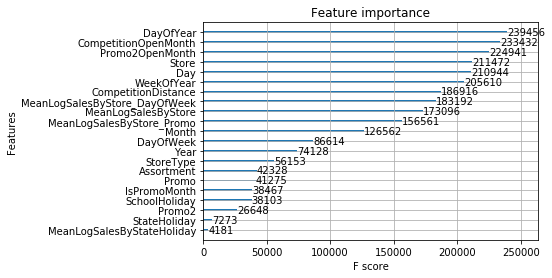

In [45]:
plot = xgb.plot_importance(gbm)
fig = plot.get_figure()
fig.savefig('MarkdownImages/features.png')

## 载入模型，进行预测

In [54]:
gbm = xgb.Booster({'nthread':4}) #init model
gbm.load_model("data/xgboost_15_with_all_features_moretrain.modelxgboost_16.model") # load data

In [55]:
features = ['Store', 'DayOfWeek',  'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
        'Promo2', 'Month', 'Day','Year','WeekOfYear','DayOfYear',
       'IsPromoMonth', 'CompetitionOpenMonth', 'Promo2OpenMonth',
        "MeanLogSalesByStore", "MeanLogSalesByStateHoliday",
        "MeanLogSalesByStore_DayOfWeek","MeanLogSalesByStore_Promo"]

In [56]:
dtest = xgb.DMatrix(test_df[features])
ypred = gbm.predict(dtest)
ypred = np.expm1(ypred)

In [58]:
data = {'Id':test_df.Id,
        'Sales':ypred}

In [59]:
out = pd.DataFrame(data).set_index('Id')

In [61]:
out.to_csv('submission_15.csv')